In [199]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [200]:
#Reading in dataframe that merges Iowa healthcare plan data with Iowa census economic data
modeling_df = pd.read_csv('combined_df.csv')
modeling_df.head()

,Unnamed: 0,County,Popul_16_Over,Unemployment_Rate,Not_in_Labor_Force_Pct,Female_Popul_16_Over,Avg_Commute_Minutes,Per_capita_income,Median_Income,Median_Male_Income,...,Metal_Level_Gold,Metal_Level_Platinum,Metal_Level_Silver,Freedom_Life_Ins_Co,Gundersen_Ins_Co,Medica_Ins_Co,Wellmark_Health_Plan_Iowa_Ins_Co,Wellmark_Synergy_Health_Ins_Co,Wellmark_Value_Health_Plan_Ins_Co,Wellmark_Ins_Co
0,0,Calhoun,7933,1.3,43.4,3854,20.4,27370,26657,44283,...,0,0,0,1,0,0,0,0,0,0
1,1,Calhoun,7933,1.3,43.4,3854,20.4,27370,26657,44283,...,0,0,0,1,0,0,0,0,0,0
2,2,Calhoun,7933,1.3,43.4,3854,20.4,27370,26657,44283,...,0,0,0,1,0,0,0,0,0,0
3,3,Calhoun,7933,1.3,43.4,3854,20.4,27370,26657,44283,...,0,0,0,1,0,0,0,0,0,0
4,4,Calhoun,7933,1.3,43.4,3854,20.4,27370,26657,44283,...,0,0,0,1,0,0,0,0,0,0


In [201]:
#modeling_df.columns

Index(['Unnamed: 0', 'County', 'Popul_16_Over', 'Unemployment_Rate',
       'Not_in_Labor_Force_Pct', 'Female_Popul_16_Over', 'Avg_Commute_Minutes',
       'Per_capita_income', 'Median_Income', 'Median_Male_Income',
       'Median_Female_Income', 'Priv_Health_Ins_Pct', 'Pub_Health_Ins_Pct',
       'No_Health_Ins_Pct', 'Poverty_Rate_Total', 'Poverty_Rate_Over_65',
       'Poverty_Rate_Children', 'Age', 'Non_Tobacco_Premium',
       'Tobacco_Premium', 'Rating_Area_2', 'Rating_Area_3', 'Rating_Area_4',
       'Rating_Area_5', 'Rating_Area_6', 'Rating_Area_7', 'Marketplace_On',
       'Metal_Level_Catastrophic', 'Metal_Level_Gold', 'Metal_Level_Platinum',
       'Metal_Level_Silver', 'Freedom_Life_Ins_Co', 'Gundersen_Ins_Co',
       'Medica_Ins_Co', 'Wellmark_Health_Plan_Iowa_Ins_Co',
       'Wellmark_Synergy_Health_Ins_Co', 'Wellmark_Value_Health_Plan_Ins_Co',
       'Wellmark_Ins_Co'],
      dtype='object')

In [202]:
#Setting random state for entire notebook to get results that can be reproduced
np.random.seed(42)

In [203]:
#Look at column info to check for null values and make sure datatypes will work for modeling
modeling_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251160 entries, 0 to 251159
Data columns (total 38 columns):
Unnamed: 0                           251160 non-null int64
County                               251160 non-null object
Popul_16_Over                        251160 non-null int64
Unemployment_Rate                    251160 non-null float64
Not_in_Labor_Force_Pct               251160 non-null float64
Female_Popul_16_Over                 251160 non-null int64
Avg_Commute_Minutes                  251160 non-null float64
Per_capita_income                    251160 non-null int64
Median_Income                        251160 non-null int64
Median_Male_Income                   251160 non-null int64
Median_Female_Income                 251160 non-null int64
Priv_Health_Ins_Pct                  251160 non-null float64
Pub_Health_Ins_Pct                   251160 non-null float64
No_Health_Ins_Pct                    251160 non-null float64
Poverty_Rate_Total                   251160 non-nu

In [204]:
#drop unnamed column that is duplicate of index value column
modeling_df = modeling_df.drop(columns = ['Unnamed: 0'])

Will use the function below to evaluate models and decide which variables to use in subsequent models.

In [205]:
def split_and_validate_models(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate each linear regression model, and report results
    Will use this function to evaluate and subsequently adjust models
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2)
    
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train.values)
    X_val_scaled = scaler.transform(X_val.values)
    
    
    # fit linear regression to training data
    ridge_model = Ridge(alpha=10)
    ridge_model.fit(X_train_scaled, y_train)
    lasso_model = Lasso(alpha=10)
    lasso_model.fit(X_train_scaled, y_train)
    
    
    # score fit model on validation data
    lr_score = lr_model.score(X_val, y_val)
    ridge_score = ridge_model.score(X_val_scaled, y_val)
    lasso_score = lasso_model.score(X_val_scaled, y_val)
    
    #print results
    print('\nLin_Reg Validation R^2 score:', lr_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 
    print('\nRidge Validation R^2 score:', ridge_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, ridge_model.coef_):
        print(feature, ':', f'{coef:.2f}') 
    print('\nLasso Validation R^2 score:', lasso_score)
    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lasso_model.coef_):
        print(feature, ':', f'{coef:.2f}') 

To attempt feature engineering that could have predictive value, I will create the following columns: 

Female population percentage for each county, difference between median income among female and male residents of each county, as well as a columns that multiples those two new values. Also creating columns for the percentage of people out of the labor force times the uninsured population, and the new poverty rate times the percentage of people with public rather than private health insurance.


In [206]:
modeling_df['Female_Popul_Pct'] = modeling_df['Female_Popul_16_Over'] / modeling_df['Popul_16_Over']
modeling_df['Med_Income_Gender_Diff'] = modeling_df['Median_Male_Income'] - modeling_df['Median_Female_Income']
modeling_df['Uninsured_Not_in_Labor_Force_Pct'] = modeling_df['Not_in_Labor_Force_Pct'] * modeling_df['No_Health_Ins_Pct']
modeling_df['Pub_Ins_x_Pov_Rate_Total_Pct'] = modeling_df['Poverty_Rate_Total'] * modeling_df['Pub_Health_Ins_Pct']
modeling_df['Female_Pop_x_Income_Diff'] = modeling_df['Female_Popul_Pct'] * modeling_df['Med_Income_Gender_Diff']


In [207]:
#modeling_df.columns

In [208]:
#Looking at correlations with our target variable Non_Tobacco_Premium 
#as a gage for which variables would be good to include in model
modeling_df.corr()['Non_Tobacco_Premium'].sort_values(ascending=False)

Non_Tobacco_Premium                  1.000000
Tobacco_Premium                      0.993961
Age                                  0.819287
Metal_Level_Silver                   0.192888
Wellmark_Ins_Co                      0.158921
Metal_Level_Platinum                 0.131958
Gundersen_Ins_Co                     0.113525
Metal_Level_Gold                     0.110452
Rating_Area_7                        0.076043
Wellmark_Health_Plan_Iowa_Ins_Co     0.037943
Not_in_Labor_Force_Pct               0.030123
Pub_Health_Ins_Pct                   0.028987
Wellmark_Value_Health_Plan_Ins_Co    0.027375
Poverty_Rate_Children                0.024353
Pub_Ins_x_Pov_Rate_Total_Pct         0.021701
Uninsured_Not_in_Labor_Force_Pct     0.015838
Poverty_Rate_Total                   0.013959
No_Health_Ins_Pct                    0.012090
Rating_Area_5                        0.010905
Poverty_Rate_Over_65                 0.005906
Wellmark_Synergy_Health_Ins_Co       0.001528
Unemployment_Rate                 

I will remove Tobacco premium, as it is multicollinear with the target variable.

In [209]:
#remove Tobacco_Premium since its multicollinear with the target variable
modeling_df = modeling_df.drop(columns = ['Tobacco_Premium'])

Start by running a model with all numeric variables.

In [210]:
y = modeling_df.Non_Tobacco_Premium
X = modeling_df.drop(columns = ['Non_Tobacco_Premium', 'County'])

In [211]:
split_and_validate_models(X, y)


Lin_Reg Validation R^2 score: 0.8434253985291821
Feature coefficient results: 

Popul_16_Over : 0.00
Unemployment_Rate : 0.35
Not_in_Labor_Force_Pct : -0.30
Female_Popul_16_Over : -0.00
Avg_Commute_Minutes : -0.05
Per_capita_income : 0.00
Median_Income : 0.00
Median_Male_Income : 794040418.46
Median_Female_Income : -794040418.46
Priv_Health_Ins_Pct : -0.17
Pub_Health_Ins_Pct : -0.17
No_Health_Ins_Pct : -1.48
Poverty_Rate_Total : -0.17
Poverty_Rate_Over_65 : -0.08
Poverty_Rate_Children : 0.01
Age : 15.92
Rating_Area_2 : -50.15
Rating_Area_3 : -10.76
Rating_Area_4 : 1.70
Rating_Area_5 : -4.85
Rating_Area_6 : -43.81
Rating_Area_7 : 4.84
Marketplace_On : 48.99
Metal_Level_Catastrophic : -57.45
Metal_Level_Gold : 236.07
Metal_Level_Platinum : 332.43
Metal_Level_Silver : 132.78
Freedom_Life_Ins_Co : 204.03
Gundersen_Ins_Co : 158.64
Medica_Ins_Co : 103.21
Wellmark_Health_Plan_Iowa_Ins_Co : 166.59
Wellmark_Synergy_Health_Ins_Co : 118.33
Wellmark_Value_Health_Plan_Ins_Co : 125.24
Wellmark_Ins_

The Lasso and Ridge models have a coefficient for age that is several times higher than for any other variable. I will remove age from the models since it has by far the strongest correlation with the target variable (Non_Tobacco_Premium), and it is already widely known that health insurance premiums are explicitly based upon age. 

In addition, having age as the only X variable produces nearly the same model r-squared scores as having age plus any combination of X variables. I will investigate what other variables can help predict health insurance premiums.

In [212]:
y = modeling_df.Non_Tobacco_Premium
X = modeling_df.drop(columns = ['Non_Tobacco_Premium', 'County', 'Age'])

In [213]:
split_and_validate_models(X, y)


Lin_Reg Validation R^2 score: 0.17306568254806287
Feature coefficient results: 

Popul_16_Over : -0.00
Unemployment_Rate : 0.07
Not_in_Labor_Force_Pct : -0.00
Female_Popul_16_Over : 0.00
Avg_Commute_Minutes : -0.02
Per_capita_income : 0.00
Median_Income : -0.00
Median_Male_Income : 509952775.94
Median_Female_Income : -509952775.94
Priv_Health_Ins_Pct : -0.08
Pub_Health_Ins_Pct : 0.04
No_Health_Ins_Pct : -1.04
Poverty_Rate_Total : 0.85
Poverty_Rate_Over_65 : 0.26
Poverty_Rate_Children : 0.10
Rating_Area_2 : -49.34
Rating_Area_3 : -10.15
Rating_Area_4 : 2.96
Rating_Area_5 : -4.67
Rating_Area_6 : -45.35
Rating_Area_7 : 6.01
Marketplace_On : 48.54
Metal_Level_Catastrophic : -56.67
Metal_Level_Gold : 236.53
Metal_Level_Platinum : 331.68
Metal_Level_Silver : 132.26
Freedom_Life_Ins_Co : 204.76
Gundersen_Ins_Co : 157.16
Medica_Ins_Co : 102.16
Wellmark_Health_Plan_Iowa_Ins_Co : 165.15
Wellmark_Synergy_Health_Ins_Co : 117.62
Wellmark_Value_Health_Plan_Ins_Co : 126.13
Wellmark_Ins_Co : 237.65
F

Model $r^{2}$  is quite low now, so will look at the target variable distribution to see if it should be transformed.

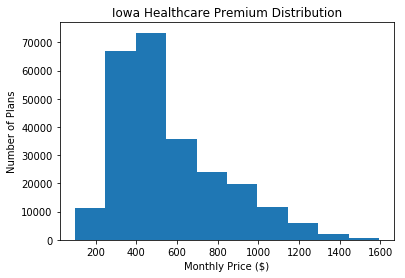

In [54]:
plt.hist(modeling_df.Non_Tobacco_Premium,bins=10)
plt.title('Iowa Healthcare Premium Distribution')
plt.xlabel('Monthly Price ($)')
plt.ylabel('Number of Plans')
plt.show()

Since premiums are not normally distributed and model $r^{2}$  without transforming the target variable is only .17, I will add a column that is the log of the Healthcare premium price. Will use this to see if independent features are more correlated with this measure as the target variable.

In [55]:
modeling_df['Log_Premium'] = np.log(modeling_df['Non_Tobacco_Premium'])

In [56]:
modeling_df.corr()['Log_Premium'].sort_values(ascending=False)

Log_Premium                          1.000000
Non_Tobacco_Premium                  0.967424
Age                                  0.838252
Metal_Level_Silver                   0.211683
Wellmark_Ins_Co                      0.165571
Gundersen_Ins_Co                     0.115907
Metal_Level_Platinum                 0.115138
Metal_Level_Gold                     0.107346
Rating_Area_7                        0.077581
Wellmark_Health_Plan_Iowa_Ins_Co     0.053448
Not_in_Labor_Force_Pct               0.039732
Pub_Health_Ins_Pct                   0.038027
Wellmark_Value_Health_Plan_Ins_Co    0.037609
Poverty_Rate_Children                0.031125
Pub_Ins_x_Pov_Rate_Total_Pct         0.029686
Uninsured_Not_in_Labor_Force_Pct     0.022446
Rating_Area_5                        0.019979
Poverty_Rate_Total                   0.019719
No_Health_Ins_Pct                    0.017490
Poverty_Rate_Over_65                 0.007370
Wellmark_Synergy_Health_Ins_Co       0.005067
Rating_Area_3                     

Since features have a slightly stronger correlation with Log_Premium, will run models with Log_Premium as target variable.

In [62]:
y = modeling_df.Log_Premium
X = modeling_df.drop(columns = ['Non_Tobacco_Premium', 'County', 'Age', 'Log_Premium'])

In [63]:
split_and_validate_models(X, y)


Lin_Reg Validation R^2 score: 0.20679283077825872
Feature coefficient results: 

Popul_16_Over : -0.00
Unemployment_Rate : 0.00
Not_in_Labor_Force_Pct : -0.00
Female_Popul_16_Over : 0.00
Avg_Commute_Minutes : 0.00
Per_capita_income : 0.00
Median_Income : -0.00
Median_Male_Income : 2159696.83
Median_Female_Income : -2159696.83
Priv_Health_Ins_Pct : -0.00
Pub_Health_Ins_Pct : 0.00
No_Health_Ins_Pct : -0.00
Poverty_Rate_Total : 0.00
Poverty_Rate_Over_65 : 0.00
Poverty_Rate_Children : -0.00
Rating_Area_2 : -0.11
Rating_Area_3 : -0.02
Rating_Area_4 : 0.01
Rating_Area_5 : -0.01
Rating_Area_6 : -0.10
Rating_Area_7 : -0.00
Marketplace_On : 0.09
Metal_Level_Catastrophic : -0.17
Metal_Level_Gold : 0.38
Metal_Level_Platinum : 0.49
Metal_Level_Silver : 0.24
Freedom_Life_Ins_Co : 0.39
Gundersen_Ins_Co : 0.32
Medica_Ins_Co : 0.21
Wellmark_Health_Plan_Iowa_Ins_Co : 0.32
Wellmark_Synergy_Health_Ins_Co : 0.23
Wellmark_Value_Health_Plan_Ins_Co : 0.24
Wellmark_Ins_Co : 0.43
Female_Popul_Pct : 0.14
Med_I

While running the model with the log transformed target variable produces a slightly higher $r^2$ for Ridge and Linear Regression, the model is not interpretable with all coefficients zeroed out. Therefore, will use the non-transformed premium price as the target variable for the final model.

The following lists and correlation plots are just for illustrative purposes to be included in the presentation.
Modeling continues right after.


In [194]:
healthcare_plan_features = ['Age', 'Rating_Area_2', 'Rating_Area_3', 'Rating_Area_4', 'Rating_Area_5', 'Rating_Area_6', 'Rating_Area_7',
                           'Marketplace_On', 'Metal_Level_Silver', 'Metal_Level_Gold', 'Metal_Level_Platinum', 'Metal_Level_Catastrophic',
                           'Freedom_Life_Ins_Co', 'Medica_Ins_Co', 'Wellmark_Ins_Co', 'Gundersen_Ins_Co',
                            'Wellmark_Health_Plan_Iowa_Ins_Co', 'Wellmark_Value_Health_Plan_Ins_Co', 'Non_Tobacco_Premium']

In [195]:
census_features = ['Non_Tobacco_Premium', 'Median_Income', 'Not_in_Labor_Force_Pct', 'Pub_Health_Ins_Pct', 'Poverty_Rate_Children', 'Pub_Ins_x_Pov_Rate_Total_Pct', 'Uninsured_Not_in_Labor_Force_Pct', 'Poverty_Rate_Total', 'No_Health_Ins_Pct', 'Poverty_Rate_Over_65',
                   'Unemployment_Rate', 'Female_Popul_Pct', 'Med_Income_Gender_Diff', 'Female_Pop_x_Income_Diff', 'Priv_Health_Ins_Pct', 'Per_capita_income']  
                   

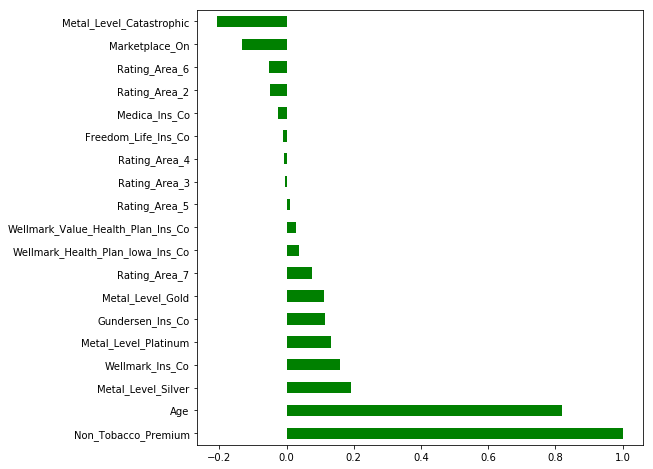

In [59]:
plt.rcParams['figure.figsize'] = [8, 8]
healthcare_plan_corr = modeling_df[healthcare_plan_features].corr()['Non_Tobacco_Premium'].sort_values(ascending=False).plot(kind='barh', color='Green');
fig1 = healthcare_plan_corr.get_figure()
fig1.savefig('healthcare_plan_corr.png', bbox_inches = 'tight')

In [ ]:
plt.rcParams['figure.figsize'] = [8, 8]
census_corr = modeling_df[census_features].corr()['Non_Tobacco_Premium'].sort_values(ascending=False).plot(kind='barh', color='Purple');
fig2 = census_corr.get_figure()
fig2.savefig('census_corr.png', bbox_inches = 'tight')



I will now run models that remove variables related to job status, income, female population, commute, poverty rates, and type of health insurance held, since they all have correlations with premium price below 0.05, and model coefficents at or near zero. new_x below contains remaining variables. 

In [118]:
#New list of features that excludes columns explained above
new_x = ['Metal_Level_Silver', 'Wellmark_Ins_Co', 'Metal_Level_Platinum', 'Metal_Level_Gold',                   
        'Wellmark_Health_Plan_Iowa_Ins_Co', 'Wellmark_Value_Health_Plan_Ins_Co', 'Rating_Area_7',
        'Freedom_Life_Ins_Co', 'Medica_Ins_Co', 'Marketplace_On', 'Rating_Area_6', 'Rating_Area_5',
         'Rating_Area_2', 'Rating_Area_3', 'Rating_Area_4', 'Metal_Level_Catastrophic', 'Gundersen_Ins_Co']

In [119]:
y = modeling_df.Non_Tobacco_Premium
X = modeling_df[new_x]

In [120]:
split_and_validate_models(X, y)


Lin_Reg Validation R^2 score: 0.16929433267106264
Feature coefficient results: 

Metal_Level_Silver : 129.97
Wellmark_Ins_Co : 194.51
Metal_Level_Platinum : 332.56
Metal_Level_Gold : 247.43
Wellmark_Health_Plan_Iowa_Ins_Co : 122.29
Wellmark_Value_Health_Plan_Ins_Co : 102.80
Rating_Area_7 : 6.26
Freedom_Life_Ins_Co : 157.33
Medica_Ins_Co : 92.63
Marketplace_On : 13.61
Rating_Area_6 : -38.53
Rating_Area_5 : 6.75
Rating_Area_2 : -52.93
Rating_Area_3 : -9.44
Rating_Area_4 : 0.37
Metal_Level_Catastrophic : -63.66
Gundersen_Ins_Co : 146.63

Ridge Validation R^2 score: 0.16929357218647514
Feature coefficient results: 

Metal_Level_Silver : 64.90
Wellmark_Ins_Co : 71.91
Metal_Level_Platinum : 35.78
Metal_Level_Gold : 37.39
Wellmark_Health_Plan_Iowa_Ins_Co : 48.83
Wellmark_Value_Health_Plan_Ins_Co : 29.96
Rating_Area_7 : 2.50
Freedom_Life_Ins_Co : 29.41
Medica_Ins_Co : 26.89
Marketplace_On : 6.73
Rating_Area_6 : -15.33
Rating_Area_5 : 2.37
Rating_Area_2 : -12.02
Rating_Area_3 : -3.16
Rating_Ar

This smaller set of dependent variables in x_new produces an $r^{2}$ score very similar to using the full set of dependent variables without age, so will try to cut the list down further by removing some rating areas. 

In [145]:
new_x2 = ['Metal_Level_Silver', 'Wellmark_Ins_Co', 'Metal_Level_Platinum', 'Metal_Level_Gold',                   
         'Wellmark_Value_Health_Plan_Ins_Co', 'Wellmark_Health_Plan_Iowa_Ins_Co',
        'Freedom_Life_Ins_Co', 'Medica_Ins_Co', 'Rating_Area_2', 'Rating_Area_6', 'Marketplace_On', 'Metal_Level_Catastrophic', 'Gundersen_Ins_Co']

In [146]:
y = modeling_df.Non_Tobacco_Premium
X = modeling_df[new_x2]

In [147]:
split_and_validate_models(X, y)


Lin_Reg Validation R^2 score: 0.17016660698182817
Feature coefficient results: 

Metal_Level_Silver : 130.33
Wellmark_Ins_Co : 193.70
Metal_Level_Platinum : 323.39
Metal_Level_Gold : 246.84
Wellmark_Value_Health_Plan_Ins_Co : 101.20
Wellmark_Health_Plan_Iowa_Ins_Co : 120.63
Freedom_Life_Ins_Co : 157.45
Medica_Ins_Co : 94.36
Rating_Area_2 : -52.40
Rating_Area_6 : -41.07
Marketplace_On : 13.41
Metal_Level_Catastrophic : -64.53
Gundersen_Ins_Co : 150.92

Ridge Validation R^2 score: 0.17016596705461207
Feature coefficient results: 

Metal_Level_Silver : 65.07
Wellmark_Ins_Co : 71.43
Metal_Level_Platinum : 34.81
Metal_Level_Gold : 37.43
Wellmark_Value_Health_Plan_Ins_Co : 29.47
Wellmark_Health_Plan_Iowa_Ins_Co : 48.15
Freedom_Life_Ins_Co : 29.45
Medica_Ins_Co : 27.45
Rating_Area_2 : -11.92
Rating_Area_6 : -16.34
Marketplace_On : 6.62
Metal_Level_Catastrophic : -16.79
Gundersen_Ins_Co : 43.89

Lasso Validation R^2 score: 0.13906822253311923
Feature coefficient results: 

Metal_Level_Silver 

By removing some rating areas, model $r^2$ stays very similar. We will see if we can maintain or increase $r^2$ by removing more variables using new_x3 below.

In [142]:
new_x3 = ['Metal_Level_Silver', 'Wellmark_Ins_Co', 'Metal_Level_Platinum', 'Metal_Level_Gold',                   
         'Wellmark_Value_Health_Plan_Ins_Co', 'Marketplace_On',
        'Freedom_Life_Ins_Co', 'Medica_Ins_Co', 'Metal_Level_Catastrophic', 'Gundersen_Ins_Co']

In [143]:
y = modeling_df.Non_Tobacco_Premium
X = modeling_df[new_x3]

In [144]:
split_and_validate_models(X, y)


Lin_Reg Validation R^2 score: 0.15737381050861154
Feature coefficient results: 

Metal_Level_Silver : 130.12
Wellmark_Ins_Co : 88.09
Metal_Level_Platinum : 332.42
Metal_Level_Gold : 250.21
Wellmark_Value_Health_Plan_Ins_Co : 58.82
Marketplace_On : -86.21
Freedom_Life_Ins_Co : 53.03
Medica_Ins_Co : 89.58
Metal_Level_Catastrophic : -70.98
Gundersen_Ins_Co : 134.99

Ridge Validation R^2 score: 0.1573736246911568
Feature coefficient results: 

Metal_Level_Silver : 64.97
Wellmark_Ins_Co : 32.51
Metal_Level_Platinum : 35.80
Metal_Level_Gold : 37.82
Wellmark_Value_Health_Plan_Ins_Co : 17.15
Marketplace_On : -42.86
Freedom_Life_Ins_Co : 9.93
Medica_Ins_Co : 26.13
Metal_Level_Catastrophic : -18.42
Gundersen_Ins_Co : 39.24

Lasso Validation R^2 score: 0.13601325825199695
Feature coefficient results: 

Metal_Level_Silver : 44.60
Wellmark_Ins_Co : 21.87
Metal_Level_Platinum : 25.41
Metal_Level_Gold : 24.97
Wellmark_Value_Health_Plan_Ins_Co : 0.41
Marketplace_On : -23.43
Freedom_Life_Ins_Co : 0.00

By further removing any variables from x2_new, such as insurance companies, the final two rating areas, or whether the plan is on the healthcare marketplace, model validation $r^2$ is reduced by at least .5. I will now input variables from new_x2 above into Statsmodels and keep all of them for our final model if they all have low p-values. 

In [148]:
#Variables in x_new are the dependent variables[
lm1 = smf.ols('Non_Tobacco_Premium ~ Metal_Level_Silver + Wellmark_Ins_Co + Rating_Area_6 + Rating_Area_2 + Metal_Level_Platinum + Metal_Level_Gold + Wellmark_Health_Plan_Iowa_Ins_Co + Wellmark_Value_Health_Plan_Ins_Co + Freedom_Life_Ins_Co + Medica_Ins_Co + Marketplace_On + Metal_Level_Catastrophic + Gundersen_Ins_Co', data=modeling_df)
fit1 = lm1.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Non_Tobacco_Premium   R-squared:                       0.168
Model:                             OLS   Adj. R-squared:                  0.168
Method:                  Least Squares   F-statistic:                     3909.
Date:                 Sun, 21 Apr 2019   Prob (F-statistic):               0.00
Time:                         12:27:05   Log-Likelihood:            -1.7278e+06
No. Observations:               251160   AIC:                         3.456e+06
Df Residuals:                   251146   BIC:                         3.456e+06
Df Model:                           13                                         
Covariance Type:             nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           394.4397      2.741    143.925      0.000     389.068     399.811
Metal_Level_Silver                  130.4369      1.071    121.797      0.000     128.338     132.536
Wellmark_Ins_Co                     193.8731      2.894     66.996      0.000     188.201     199.545
Rating_Area_6                       -41.2481      1.215    -33.939      0.000     -43.630     -38.866
Rating_Area_2                       -52.4549      2.079    -25.236      0.000     -56.529     -48.381
Metal_Level_Platinum                330.6674      4.689     70.513      0.000     321.476     339.859
Metal_Level_Gold                    248.7711      3.276     75.937      0.000     242.350     255.192
Wellmark_Health_Plan_Iowa_Ins_Co    121.9803      2.851     42.783      0.000     116.392     127.569
Wellmark_Value_Health_Plan_Ins_Co   102.6961      1.993     51.536      0.000      98.790     106.602
Freedom_Life_Ins_Co                 158.3970      3.670     43.158      0.000     151.204     165.590
Medica_Ins_Co                        94.3937      1.769     53.365      0.000      90.927      97.861
Marketplace_On                       13.9444      2.606      5.351      0.000       8.837      19.052
Metal_Level_Catastrophic            -64.0640      2.037    -31.444      0.000     -68.057     -60.071
Gundersen_Ins_Co                    150.4448      1.927     78.085      0.000     146.669     154.221
==============================================================================
Omnibus:                    25226.129   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33743.228
Skew:                           0.897   Prob(JB):                         0.00
Kurtosis:                       2.920   Cond. No.                         17.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Since all variables in Statsmodels above help increase $r^2$ squared, and have p-values approaching zero, we will keep them for our final model. Our final set of variables is new_x2.

Now I will plot actual vs predicted values to see if the errors uncorrelated

Text(0, 0.5, 'Predicted Y Values')

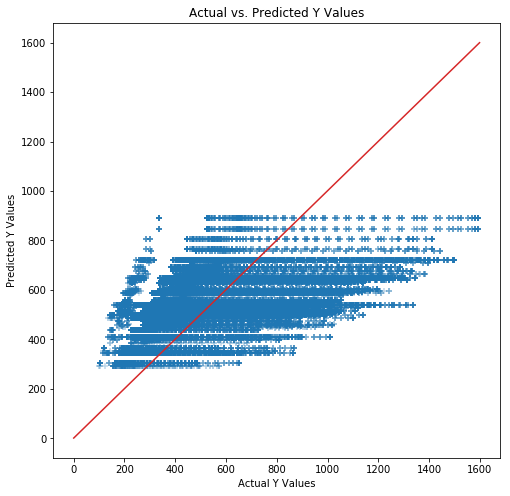

In [149]:
X = modeling_df[new_x2]
#Need to do train_test_split and create model since only done within functions to this point
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
lr_model = LinearRegression()
lr_model_fit = lr_model.fit(X_train, y_train)
y_pred = lr_model_fit.predict(X_train)

plt.scatter(y_train,y_pred, marker='+', alpha=0.1) 
plt.plot(np.linspace(1,1600,1600), 'tab:red')
plt.title('Actual vs. Predicted Y Values')
plt.xlabel('Actual Y Values')
plt.ylabel('Predicted Y Values')

The relationship between actual and predicted values is non-linear so we may need to correct that.

Will now plot residuals to look for a relationship

Text(0, 0.5, 'Residuals')

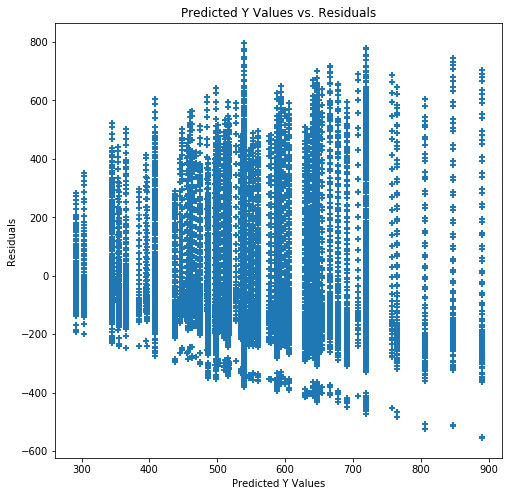

In [151]:
residuals = y_train.values-y_pred

#plot actual observation against residual
plt.scatter(y_pred, residuals, marker='+') 
plt.title('Predicted Y Values vs. Residuals')
plt.xlabel('Predicted Y Values')
plt.ylabel('Residuals')

The residual plot clearly shows heteroskedasticity, which needs to be corrected. Will look at relationships between variables 
to decide what to do.

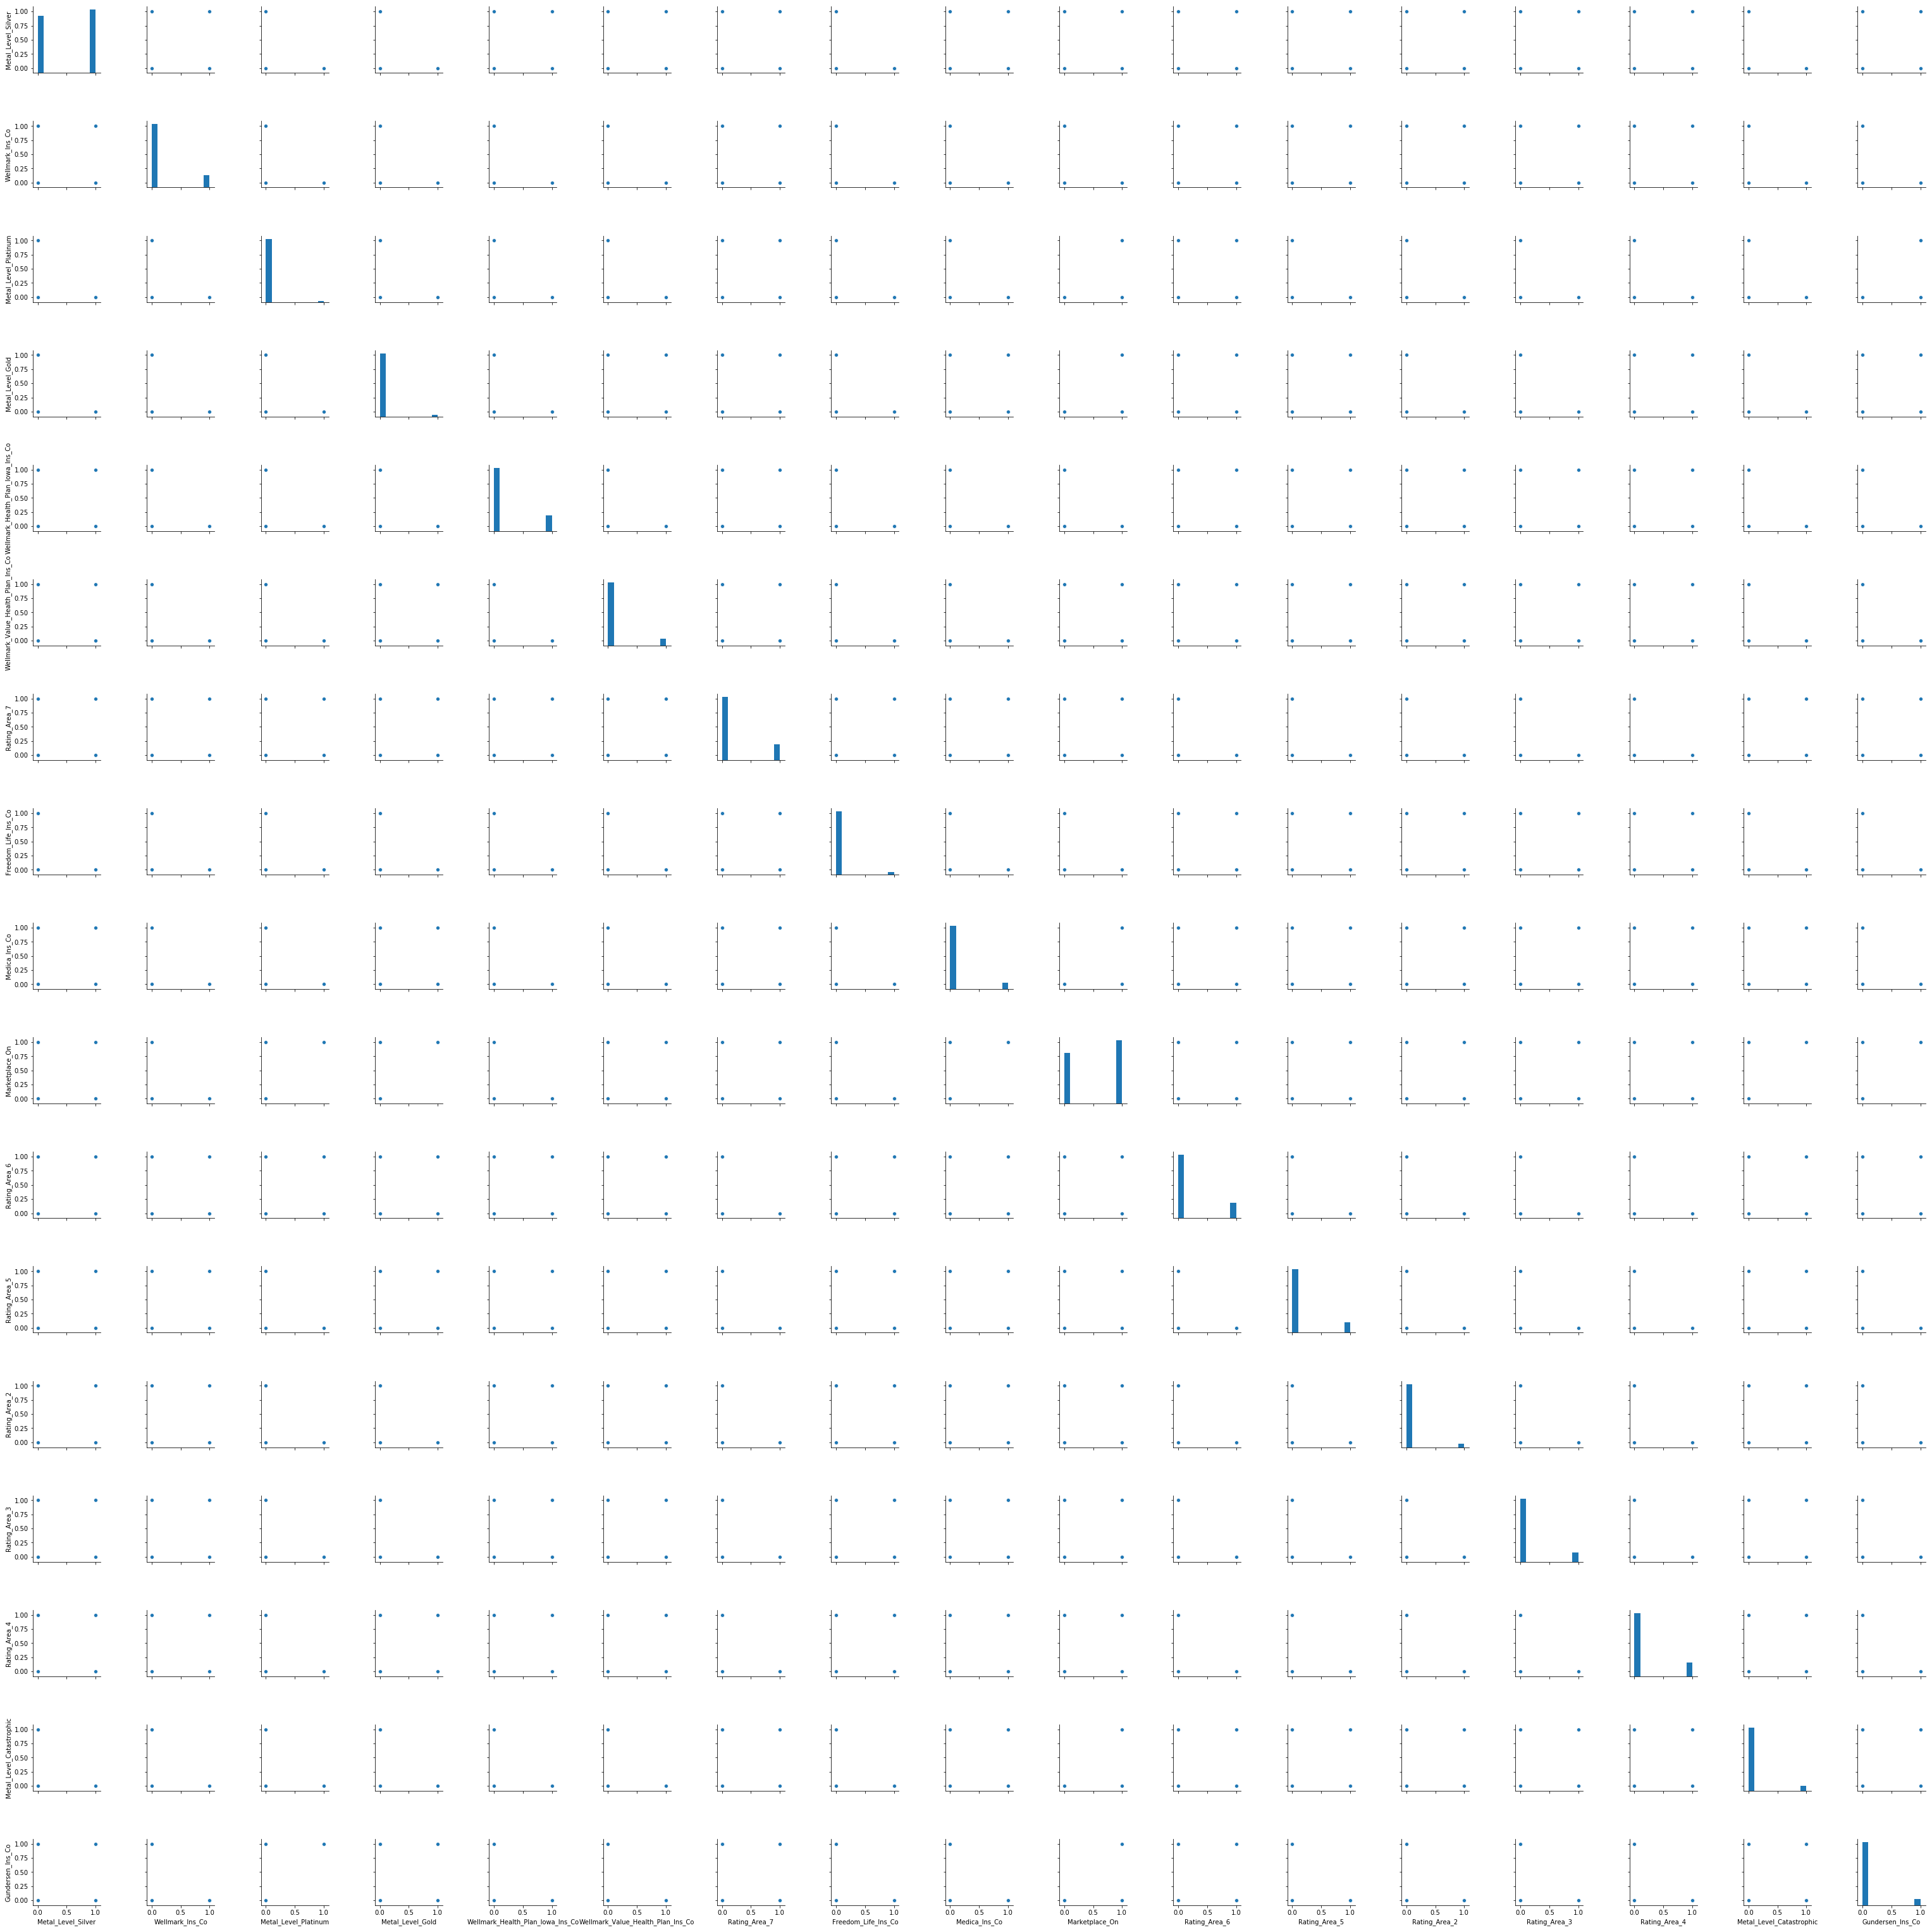

In [41]:
pairplot = sns.pairplot(modeling_df[new_x]) 

The pairplots only include categorical variables, so cannot gather much from pairplot. It is generally not advised to use a linear regression model without continuous variables. However, none of my continuous variables improved the model. 

Will try polynomial regression to see if it corrects for skewed residuals.

In [28]:
def polynomial_linear_regression(degree, polynomial_r2_scores, polynomial_RMSE_scores):
    polynom_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    polynom_fit = polynom_model.fit(X_train, y_train)
    polynomial_r2_scores.append(polynom_fit.score(X_train,y_train))
    polynom_predict = polynom_fit.predict(X_train)
    polynomial_RMSE_scores.append(np.sqrt(mean_squared_error(y_train,polynom_predict)))
    return polynomial_r2_scores, polynomial_RMSE_scores

In [29]:
polynomial_r2_scores = []
polynomial_RMSE_scores = []
for degree in range(1,6):
    polynomial_linear_regression(degree, polynomial_r2_scores, polynomial_RMSE_scores)

for i in range(len(polynomial_r2_scores)):
    print('Polynomial degree: %s'%(i+1))
    print('Train R Sqr: %s''\n'
           'Train RMSE: $%s' %(polynomial_r2_scores[i],polynomial_RMSE_scores[i]))
    print('')


Polynomial degree: 1
Train R Sqr: 0.1686432669671706
Train RMSE: $235.66058842864288

Polynomial degree: 2
Train R Sqr: 0.17999348121905878
Train RMSE: $234.0463652950488

Polynomial degree: 3
Train R Sqr: 0.1802821012932564
Train RMSE: $234.00517268084346

Polynomial degree: 4
Train R Sqr: 0.18015721548882924
Train RMSE: $234.02299760041586

Polynomial degree: 5
Train R Sqr: 0.18027215046512443
Train RMSE: $234.00659300983241



In [37]:
degree = 4
polynom_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
polynom_fit = polynom_model.fit(X_train, y_train)
polynomial_r2_score = polynom_fit.score(X_train,y_train)
polynom_predict = polynom_fit.predict(X_train)
polynomial_RMSE_score = np.sqrt(mean_squared_error(y_train,polynom_predict))

Text(0, 0.5, 'Predicted Y Values')

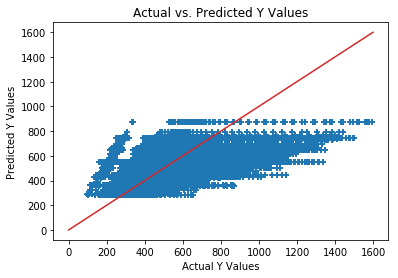

In [38]:
plt.scatter(y_train,polynom_predict, marker='+')
plt.plot(np.linspace(1,1600,1600), 'tab:red')
plt.title('Actual vs. Predicted Y Values')
plt.xlabel('Actual Y Values')
plt.ylabel('Predicted Y Values')

Text(0, 0.5, 'Residuals')

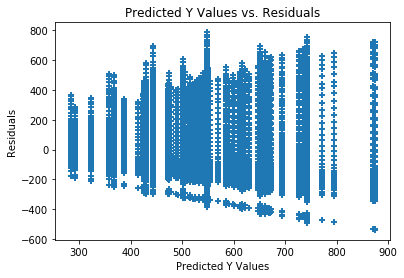

In [39]:
polynomial_predict_residual = y_train.values - polynom_predict

plt.scatter(polynom_predict, polynomial_predict_residual, marker='+') 
plt.title('Predicted Y Values vs. Residuals')
plt.xlabel('Predicted Y Values')
plt.ylabel('Residuals')

Polynomial regression still produces similar residual errors, so it will not be used in the final model.

### Final model tuning and results

In [189]:
X = modeling_df[new_x2]
y = modeling_df.Non_Tobacco_Premium

# Split data into training and holdout/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

In [190]:
model = LinearRegression()
lr_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

print(lr_scores.mean())

-55352.91270831111


Will now use GridSearch CV to get best Ridge and Lasso models.

In [175]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [183]:
model = Ridge()
parameters = {'alpha': [1e-3,1e-2,1e-1,1,1e1,1e2,1e3], 'fit_intercept': [True]}
grid = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
grid.fit(X_train_scaled, y_train)
#grid.cv_results_

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0], 'fit_intercept': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [184]:
grid.best_estimator_

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [185]:
print(grid.best_params_, grid.best_score_)

{'alpha': 1, 'fit_intercept': True} -55339.25876675338


In [186]:
model = Lasso()
parameters = {'alpha': [1e-3,1e-2,1e-1,1,1e1,1e2,1e3], 'fit_intercept': [True]}
grid = GridSearchCV(model, parameters, cv=5, scoring='neg_mean_squared_error', n_jobs=1)
grid.fit(X_train_scaled, y_train)
#grid.cv_results_

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0], 'fit_intercept': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [187]:
grid.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [188]:
print(grid.best_params_, grid.best_score_)

{'alpha': 0.001, 'fit_intercept': True} -55339.259183509595


Since there is nearly indentical mean squared error scores for each of our best Lasso and Ridge models, will use Ridge as the final model since it produces better $r^2$ score.

#### Final Model Variables and Coefficients

In [198]:
final_ridge_model = Ridge(alpha= 1, fit_intercept=False)
final_ridge_model.fit(X,y)
final_ridge_coeffs = (dict(zip(X.columns, final_ridge_model.coef_)))
final_ridge_coeffs

{'Metal_Level_Silver': 164.7339272019634,
 'Wellmark_Ins_Co': 564.9024848556281,
 'Metal_Level_Platinum': 347.2885760035268,
 'Metal_Level_Gold': 258.80307315434413,
 'Wellmark_Value_Health_Plan_Ins_Co': 267.46527214874726,
 'Wellmark_Health_Plan_Iowa_Ins_Co': 493.36012981785893,
 'Freedom_Life_Ins_Co': 548.4338204990526,
 'Medica_Ins_Co': 127.314048003657,
 'Rating_Area_2': -38.52720722584307,
 'Rating_Area_6': -16.50861221833322,
 'Marketplace_On': 348.59130266929077,
 'Metal_Level_Catastrophic': -21.153901885806643,
 'Gundersen_Ins_Co': 182.674891694444}